<a href="https://colab.research.google.com/github/aryanfaghihi/ai-course/blob/master/NLP%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Make a copy

**Follow the following steps to make your own copy. You will lose your changes if you don't make your own copy!**

From the tooltip above, you should see 

File | Edit | View | Insert | Runtime | Tools | Help

1. Click on **File**
2. Click on **Save a copy in Drive**

## Import

Let's import the required packages and setup some settings that will help us in this notebook.

In [ ]:
# import the required packages
from fastai.text import *
import warnings

# ignore Python warnings
warnings.filterwarnings("ignore")

# Data

You've probably heard of [IMDb](https://www.imdb.com/), a popular website where people write movie reviews for all kinds of movies. There are almost an infinite number of movie reviews on IMDb. Wouldn't be cool if we could build a model that can find out if a review is positive or negetive? Well, that's exactly what we'll be doing today!

This is a great example use case for **Natural Language Processing (NLP)** which is the focus of this workshop.

Today we are going to train a Natural Language Processing Model to **classify IMDb reviews**.


> At the end of this session you will be able to write a movie review and the model will be able to find out whether your movie review is positive or negative.


## Looking at data

First things first. Let's download our dataset and put it to `data` variable.
  

In [ ]:
# Download IMDB dataset
path = untar_data(URLs.IMDB_SAMPLE)
data = pd.read_csv(path/'texts.csv')

Here is a sample of our dataset:

In [ ]:
# look at the head of the data
data.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


And this is one of those reviews:

In [ ]:
# grab the column text of the data
data['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Let's use the `describe()` method to get an overview of our data grouped by `label`.

In [ ]:
data.groupby('label').describe()

text         ... is_valid     
         count unique  ...      top freq
label                  ...              
negative   524    524  ...    False  417
positive   476    476  ...    False  383

[2 rows x 8 columns]

---

How many positive/negative reviews do we have? 

---


##Tokenizing



Our dataset looks pretty clean, right? well although it is easy to read for us humans, computers disagree! Why? well, computers can only work with numbers (only 0s and 1s to be more precise). When we were working with `tabular` data you'd remember that we `cateogirized` our data which means we assigned a special number for each category. Here we do the exact same thing! However, because Deep Learning engineers like to give fancy names to everything, it is called **tokenization** in the context of NLP.

How does it work you may ask? we go through our entire dataset to find the most common works. Let's say we find the following words to be the most commons ones:

* `the` 
* `is`
* `it`
* ...

Now, we assign a unique number for each word.

* `the` -> 1
* `is` -> 2
* `it` -> 3
* ...

That's all! easy enough right? 

Well, given this process is quite manual, `fastai` has been kind enough to build this process right into `TextLMDataBunch` which automatically takes care of the process of `tokinization` process for us. All we have to do is to pass in the csv data to it! 


In [ ]:
# create the datataloder from the csv file + tokenization
data_lm = TextLMDataBunch.from_csv(path,'texts.csv')

Ok, let's have a look at the result.

In [ ]:
# look at a batch of the data
data_lm.show_batch()

idx,text
0,"got to give . xxmaj mark - xxmaj paul xxmaj xxunk also stars as the mysterious architect . \n \n xxmaj my opinion : xxmaj the xxmaj house xxmaj next xxmaj door works because of xxmaj lara xxmaj flynn xxmaj boyle and the locations ( beautiful house ) and stylish sets . xxmaj boyle is a talented and dynamic actress , not to mention absolutely stunning . xxmaj she"
1,"- cu - ler "" incident , the movie began to feel like xxunk , xxunk propaganda . i was looking for something bold . xxmaj actually , i was looking for something that might make me think , but i did n't find it here . xxmaj if you 're looking for mindless entertainment , stop here - it 's good for killing a rainy afternoon . xxmaj but"
2,"xxmaj xxunk and xxmaj pumba , the story with xxmaj xxunk and him having trouble sleeping was funny . xxmaj the xxunk bubble , and when xxmaj pumba leaves , the xxunk stop . xxmaj it 's all harmless fun , good for kids and some adults . i think this movie will last for a while because it is rather good for a straight to xxmaj video and xxup"
3,"country . xxmaj if you are looking for a good , traditional comedy , then xxmaj george xxmaj lopez is the show for you ! xxmaj the one bad thing is the title . xxmaj george xxmaj lopez ? xxmaj really ? xxmaj imagine the xxmaj fresh xxmaj prince of xxmaj xxunk - xxmaj air being "" xxmaj will xxmaj smith "" . xxmaj c'mon man ! xxmaj but otherwise"
4,"storyboard . xxmaj you certainly have the ability and desire - so do n't abuse your talent . xxbos i loved the first "" xxmaj azumi "" movie . i 've seen xxmaj ms. xxmaj ueto in a variety of her xxup tv appearances and i 've seen my fair share of samurai and ninja flicks . i have to say that this movie was much weaker than i 'd"


But wait, I don't see any numbers here? 

Well, `fastai` is smart enough to convert the numbers back to words so that we can atually read the text. But, trust me, in the background all of these words have been turned into numbers.

Just one last thing before we move on:

> It's not a great idea to tokenize every single word, since some words are quite unique and don't add much meaning to the sentence. That's why we only tokenize a portion of the most common words. 



---

You might notice words in the batch above that start with `xx...`, what do you think these words represent? (hint, read the above statement)

---

# Model

Our training process is going to be a 2-step process unlike `tabular` and `image` data that only had one step.

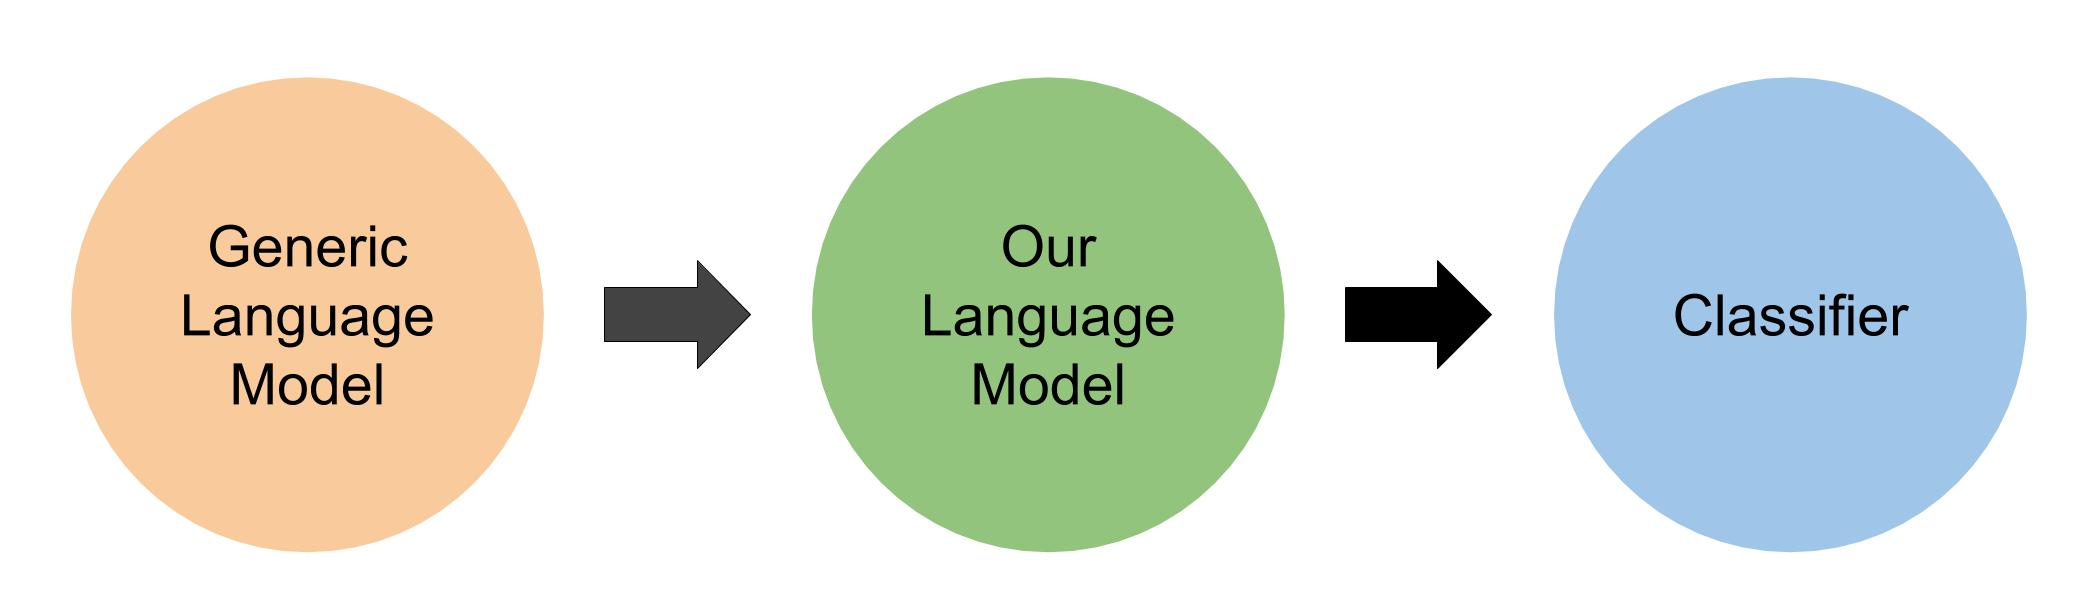

Here's the process: 

1. Start with a generic language model that understand English words and grammar
2. Fine-tune the language model for our dataset
3. Create a classifier for movie reviews

---

Why do you think we need start with a generic langauge model?

---

You don't have to! but it makes our life a lot easier. Not having a generic language model that understands English is like trying to show movie reviews to someone who doesn't speak English and expect them to differentiate them. You would expect them to first learn English, then the strucutre of movie reviews.

The same applies here, we simply do the following:

1. Learn English
2. Learn how movie reviews are written
3. Try to differentaite the positive and negative reviews

Luckily for us, the generic language model that understands English has been trained by someone else so we simply have to do the following steps:

1. **Language Model**: Train our language model on movie reviews
2. **Classifier**: Train a classifier to differentiate postive and negative reviews

Ok, now that we know what we're doing, let's start with the Language Model.

## Language Model

Let's create our dataloader first. Note that, we will need two different dataloaders since we are actually training two different models.

In [ ]:
# create dataloader for language model
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')

Now we're ready to define our model for fine-tuning our generic language model for the IMDb dataset.

In [ ]:
# create model architecture for language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

Advanced side note on the parameters:

> * `AWD_LSTM` is the architecture we will be using for training our language model. The details of this architecture is well beyond the scope of this course
* `drop_mult` is the rate for dropout. Again this is will beyond the scope of this unit. In practice though, this helps with reducing the chance of overfitting in our model.

Finding a suitable learning rate is very important when it comes to fine-tuning. Here, we are fine-tuning our langauge model. Therefore, we will need to use the `lr_find()` method to find a suitable learning rate for our use case.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


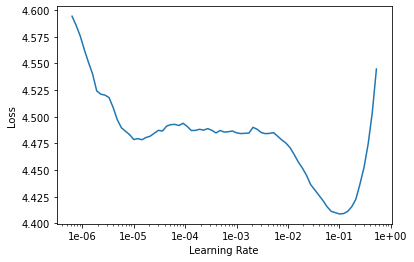

In [ ]:
# find an appropriate learning rate
learn.lr_find()
learn.recorder.plot(skip_end=15)

---

Do you remember how to use the plot above to choose an appropriate learning rate?

---

In [ ]:
# train the language model
learn.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.341276,3.910723,0.284289,00:09


You might notice we only trained our model for one epoch. It's probably a good idea to train it for a few more epochs but we will skip that for now in the interest of time.

Lastly, we will save our language model to be used for the classifer in the next section.

In [ ]:
# save the language model
learn.save_encoder('language_model')

## Classifier

Great so we've just finished training our language model on a generic language model

* [x] **Language Model**: Train our language model on movie reviews
* [ ] **Classifier**: Train a classifier to differentiate postive and negative reviews

It's time to train our **classifier**!

We need to find our dataloader for our classifier first.

In [ ]:
# create dataloader for classifier 
data_clas = TextClasDataBunch.from_csv(path,         # path to dataset
                                       'texts.csv',  # path to csv 
                                       vocab=data_lm.train_ds.vocab, # tokenizer vocab 
                                       bs=32)        # batch size

Advanced side note on `vocab`:

> remember *tokenization*? well, when you assign a unique number (token) to each word, it gets added to your **vocabulary**. We will need to use the same vocabulary for our classifier's dataloader. 

As always, let's view a batch of the data to make sure everything looks good.

In [ ]:
# view a batch of the data
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


--- 

Do you notice any differences between the output of `data_clas.show_batch()` and `data_lm.show_batch()`. Why do you think that is?

---

Awesome, finally we're at the point where we can train our classifier.

In [ ]:
# create model architecture for classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# load our language model from the previous section
learn.load_encoder('language_model');

Looking good! now, we're read to train our classifier.

In [ ]:
# train the classifier
learn.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.628219,0.607672,0.626866,00:06
1,0.562227,0.610556,0.691542,00:06
2,0.502564,0.770984,0.711443,00:06
3,0.459810,0.680205,0.731343,00:06


Ok, remember previously we used to `unfreeze()` the entire model? so that we can fine-tune the entire model? well, here we will do something slightly different. 

Instead of unfreezing the entire model, we will only unfreeze the last few layers. This will help us fine-tune parts of the model while keeping our precious language model untouched. More details reasons as to why we did this is beyond the scope of this course :(

In [ ]:
# unfreeze the last two layers only
learn.freeze_to(-2)

# train the model on the last two layers
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.523859,0.506364,0.741294,00:08


Advanced side note on `learning rate`

> here we chose a **discriminatory learning rate**. Meaning a different learning rate will be used for the first layers vs. the last layers of the model. That is what `slice` is donig here. This means (LR = learning rate):
* `slice(LR for the first layers, LR for the last layers)`
* The numbers chosen here can be found using the same `learn.lr_find()` as we've been using previously

## Testing

Now is your chance to test how our model is performing! We'e made a simple `predict()` function here that outputs: 

* Positive -> model classified the review as positive
* Negative -> model classified the review as negative

In [ ]:
def predict(sentence) :
  if learn.predict(sentence)[0]==tensor(0):
    print("Negetive")
  elif learn.predict(sentence)[0]==tensor(1):
    print("Positive")


Go on, try your own sentence! 

In [ ]:
predict("I love this movie!")

Positive


Ok this is not bad, but we can improve our model by further fine-tuning it in the next section.

##Fine Tuning

Ok so let's just recap what we've been doing so far: 

* [x] **Language Model**: Train our language model on movie reviews
* [x] **Classifier**: Train a classifier to differentiate postive and negative reviews

The steps are actually done! but we've only trained our last few layers of our model. We can fine-tune the entire architecture of our model to hopefully get a better accuracy.

As usual, for fine-tuning we need to figure out what learning rate we need. Let's use our friend `lr_finder()` to help us with this decision.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


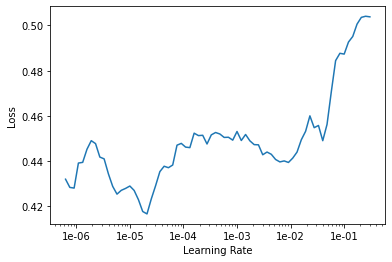

In [ ]:
# find an appropriate learning rate
learn.lr_find()
learn.recorder.plot(skip_end=15)

You'd want to spot the point where there is a steep drop before the exponential increase at the end. Here, `1e-3` seems to be a good number. 

We can follow the template below to figure out our `slice()` parameters.

> `slice(LR/(2.6**4), LR)`

This is just a practical template that works and the reasonining behind the magic number of `2.6**4` is beyond the scope of this course.

In [ ]:
# unfreeze the entire model
learn.unfreeze()

# start fine-tuning
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.454072,0.553535,0.741294,00:14
1,0.416696,0.504356,0.756219,00:13
2,0.365860,0.509058,0.781095,00:15
3,0.352765,0.507131,0.810945,00:16
4,0.306557,0.416862,0.800995,00:14
5,0.275904,0.458308,0.815920,00:17
6,0.240412,0.446390,0.810945,00:14
7,0.213938,0.470843,0.805970,00:14
8,0.207015,0.508889,0.810945,00:17
9,0.190789,0.499546,0.805970,00:16


---

Again, let's test our model! Choose your own sentences. Try some tricky ones to see how your model performs. You can always continue training the model to get better accuracy. 

---

In [ ]:
predict("The worst I have ever seen!")

Negetive


# Your turn!

## Setup

It's your turn now to play around with your dataset! Here we will be working with a subset of reviews from [Yelp](https://www.yelp.com/). The structure of the data is very similar to the IMDb dataset which we looked at previously.

Let's explore the data

In [ ]:
# download and unzip the dataset
path = untar_data(URLs.YELP_REVIEWS_POLARITY)

# look at the path structure
path.ls()

[PosixPath('/root/.fastai/data/yelp_review_polarity_csv/readme.txt'),
 PosixPath('/root/.fastai/data/yelp_review_polarity_csv/train.csv'),
 PosixPath('/root/.fastai/data/yelp_review_polarity_csv/test.csv')]

In [ ]:
# read the train.csv file
data = pd.read_csv(path/'train.csv', header=None)

In [ ]:
# print the .head of the data
### YOUR CODE HERE
data.head()

,0,1
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [ ]:
# group by column 0 and count the number of each label
## YOUR CODE HERE
data.groupby(0).describe()

## Data

Since the original dataset is too large, we will select the first 10,000 rows of it. Otherwise it will take a couple of hours to train everything! 

But you should also try training the model using the entire dataset after this workshop and compare the performance.

In [ ]:
# reduce the original dataset
data = data[:10000]

Define the test and training set. We will need to do this for this dataset manually as it has not been done for us.

In [ ]:
# train/valid split ratio
split = int(0.8*len(data))

train_df = data[:split].copy()
valid_df = data[split:].copy()

print('Training data length:', len(train_df))
print('Validation data length:', len(valid_df))

Training data length: 8000
Validation data length: 2000


### Language Model dataloader

Let's setup our Language Model dataset for training the Language Model.

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df(path, 
                                  train_df,     # training dataframe
                                  valid_df,     # validation dataframe
                                  text_cols=1,  # columns to learn from
                                  label_cols=0) # column for label

In [ ]:
# display a batch of the language model
## YOUR CODE HERE
data_lm.show_batch()

---

Can you see the labels here? If not, why not?

---

### Classifier dataloader

Define the data for the classifier

In [ ]:
# classifier data
data_cl = TextClasDataBunch.from_df(path, 
                                    train_df, # training dataframe
                                    valid_df, # validation dataframe
                                    text_cols=1, # columns to learn from
                                    label_cols=0, # column for label
                                    vocab=data_lm.train_ds.vocab, 
                                    bs=32)

In [ ]:
# view a barch of the data_cl
## YOUR CODE HERE
data_cl.show_batch()

text,target
"xxbos i xxup am xxup boycotting xxup alexander xxup 's xxup for xxup life ! ! ! xxmaj the manager xxup screamed xxup at xxup me at the top of his lungs in an epic meltdown that lasted 10 minutes ! \n \n xxmaj on xxmaj sat . , xxmaj april 12 , 2014 , i attended the 50th birthday party for my dear friend , xxmaj david xxmaj",1
xxbos i am confused . i am baffled . i am in shock . i am disappointed . \n xxmaj when i read the reviews i was a little surprised but i figured somehow i must have looked over this place after all these years and i was actually regretting it ! xxmaj now ... not so much . i quickly realized there was a reason i grew up,1
"xxbos xxmaj for many years , my best friend and her mother were season ticket holders and when her mother reached a point in age where she could no longer fully appreciate theater ( sight and hearing ) , i became the theater companion . xxmaj we 've been going now for three years , and although the overall ' experience ' of the xxmaj public is pleasant , the",1
"xxbos xxup eta 2 / 23 / 12 : xxmaj rather than shop here once a week for $ 25 ( down from my 100 - 200 bill 5 years ago ) i now shop exclusively xxmaj whole xxmaj foods , xxmaj trader xxmaj joe 's and the new xxmaj target . xxmaj there is never any reason to set foot in this xxmaj giant xxmaj eagle ever again .",1
"xxbos xxmaj the xxmaj pleasure xxmaj bar is absolutely not a 5 star restaurant , but it gets 5 stars from me bc every time i 've dined there i 've left happy , full of delicious food , and not broke . \n \n xxmaj everyone in xxmaj bloomfield knows about the xxmaj pleasure xxmaj bar , but i 'm not sure anyone outside of xxmaj bloomfield knows",2


## Model

### Language Model

Great, we're now ready to train our language model!

In [ ]:
# train the language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.139825,3.943250,0.274909,00:58


In [ ]:
# save language model to be used for classifier later on
learn.save_encoder('language_model')

### Classifier

Now that we have our language model ready, we can proceed with creating our classifier.

In [ ]:
# setup the learner for classification
learn = text_classifier_learner(data_cl, AWD_LSTM, drop_mult=0.5)

# load the language model into the classifier
learn.load_encoder('language_model');

In [ ]:
# train the last two layers
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.339061,0.256568,0.889000,00:34


Feel free to rerun the cells above to train for longer to get better accuracy.

---

Next, fine-tune your model by:

1. Finding an appropriate learning rate using `lr_finder()`
2. Using the template `slice(LR/(2.6**4), LR)` create the classifer learner

---

In [ ]:
# 1. find an appropriate learning rate
### YOUR CODE HERE


In [ ]:
# 2. fine-tune your model
### YOUR CODE HERE


## Testing

Below is a helper function to help us decode the model's prediction.

In [ ]:
# helper function to predict the results
def predict(sentence) :
  if learn.predict(sentence)[0]==tensor(0):
    print("Negetive")
  elif learn.predict(sentence)[0]==tensor(1):
    print("Positive")

Try your own sentences!

In [ ]:
# pass in your sentence to predict!
predict("This product is actually not good")

Negetive


# Summary

Today we covered:
* Basics of Natural Language Processing (NLP)
* What Tokenization is
* How to train an NLP model which includes:
  * Langauge model: to undertand English
  * Classifier: to classify a setence 
* The two step training process which consisted of: 
  * fine-tuning a language model for our purpose
  * training a classifier using our fine-tuned language model